In [35]:


import sys, os #, re, glob, socket, glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns






### 1: Functions needed for geodesic projection

In [3]:
def Mobius_addition(x,y,c):

    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # vector addition in hyperbolic space

    top = (1 + 2*c* np.dot(x,y) + c* np.dot(y,y))*x + (1-c*np.dot(x,x))*y
    bottom = 1 + 2*c* np.dot(x,y) + c**2*np.dot(x,x)*np.dot(y,y)
    return top/bottom


def Mobius_scalarMulti(x,r,c):

    # scalar vector multiplication
    # x is a N-dim vector, c is the curvature of the hyperbolic space

    result = 1/np.sqrt(c)*np.tanh(r*np.arctanh(np.sqrt( c*np.dot(x,x) ))) * x/np.sqrt(np.dot(x,x))
    return result 


def Geodesic_distance(x,y,c):
    
    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # vector addition in hyperbolic space
    direc_vector = Mobius_addition(-x,y,c)
    dist = 2/np.sqrt(c)*np.arctanh(np.sqrt(c * np.dot(direc_vector,direc_vector) ))

    return dist

def Geodesic_r(t,x,y,c):

    # find the position vector on the geodesic connecting two vectors x and y 
    # when t = 0, final_position = x
    # when t = 1, final_position = y
    direc_vector = Mobius_addition(-x,y,c)

    displace_vector = Mobius_scalarMulti(direc_vector,t,c)

    final_position = Mobius_addition(x,displace_vector,c)

    return final_position

def Geodesic_projection_OptFun(t,x,y,c,p):
    # Function that is needed to optimized to find the geometric projection t
    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # geodesic is connecting x and y
    # p is some vector 

    r_geodesic = Geodesic_r(t,x,y,c)

    dist = Geodesic_distance(p,r_geodesic,c)

    return dist


def conformal_factor(x,c):
    # deformation of the mapping from linear to hyperbolic space at position x

    lambda_c_x = 2/(1-c*np.dot(x,x))
    return lambda_c_x

def logarithmic_map(x,y,c):

    # the logarithmic_map will map a position vector y onto the tangent space at x in a hyperbolic space with curvature c
    # logarithmic_map: position in hyperbolic space -> tangent vector in tangent space
    
    minus_x_plus_y = Mobius_addition(-x,y,c)

    length_minus_x_plus_y = np.sqrt(np.dot(minus_x_plus_y,minus_x_plus_y))

    prefactor = 2/np.sqrt(c)/conformal_factor(x,c)*np.arctanh(np.sqrt(c)*length_minus_x_plus_y) 

    tangent_vector = prefactor*minus_x_plus_y/length_minus_x_plus_y

    return tangent_vector

def exponential_map(x,v,c):

    # the exponential_map will map a tangent vector v in the tangent space at x to a position vector in hyperbolic space with curvature c
    # exponential_map: tangent vector in tangent space -> position in hyperbolic space

    # first mapping the tangent vector v in linear space to vector in hyperbolic space
    length_v = np.sqrt(np.dot(v,v))
    constant_1 = np.sqrt(c)*conformal_factor(x,c)*length_v/2
    v_hyp = np.tanh(constant_1)*v/length_v/np.sqrt(c)

    # position vector in hyperbolic space:
    position_vector = Mobius_addition(x,v_hyp,c)

    return position_vector


    

### 3: doing the geometric projection

In [4]:
def hyp_to_hyp_poincare(hyp):

    t = 1
    for coord_idx in hyp.columns:

        t = t + hyp[coord_idx]**2

    t = np.sqrt(t)

    hyp_geo = hyp.copy()

    for coord_idx in hyp_geo.columns:

        hyp_geo[coord_idx] =  hyp_geo[coord_idx]/(1+t)

    return hyp_geo


In [5]:
#access hyp_emb from different notebook
%store -r sensory_pcoords

In [6]:
#  import your data as dataframe, make sure the columns only include coordinates in the hyperbolic space
df_data = pd.DataFrame(sensory_pcoords[:,0:5])

# select the point where the tangent space is located, usually at the origin
reference_point_tangent_space =  np.zeros(df_data.shape[1])

In [7]:
# transform the coordinates from native to Poincare ball
hyp_poincare = hyp_to_hyp_poincare(df_data)

# constant, this is fixed, no change
c_hyperbolicSpace = 1

# calculate the tangent vector using logrithmic map
hyp_tangent = hyp_poincare.copy()

for i in range(hyp_poincare.shape[0]):
    current_position_hyp = np.squeeze(hyp_tangent.values[i])
    hyp_tangent.iloc[i] = logarithmic_map(reference_point_tangent_space,current_position_hyp,c_hyperbolicSpace)


In [9]:
sensory_pcoords[:, 5]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
data = pd.DataFrame(np.concatenate((hyp_tangent.values, sensory_pcoords[:, 5][:, np.newaxis]), axis=1))

In [16]:
ON_means= np.mean(data.values[0:29, :], axis = 0)

In [67]:
ON_means

array([ 0.01773766, -0.0266466 , -0.06371753,  0.0358265 ,  0.09596955,
        0.        ])

In [13]:
OFF_means= np.mean(data.values[29:51, :], axis = 0)

In [14]:
OFF_means.shape

(6,)

In [17]:
#subtract ON from OFF
diff_means = OFF_means[0:5] - ON_means[0:5]

In [18]:
#normalize the difference
normalized = diff_means/np.linalg.norm(diff_means)

In [19]:
normalized

array([-0.21256496,  0.46831643,  0.43917806, -0.15385216, -0.72038046])

In [20]:
axis_trans = np.dot(data.values[:, 0:5], normalized)

In [24]:
axis_trans.shape

(51,)

In [26]:
sensory_labels = np.array(['ON']*29 + ['OFF']*22)

In [27]:
axis_trans_df = pd.DataFrame(axis_trans)

In [28]:
axis_trans_df['sensory labels'] = sensory_labels

In [25]:
axis_trans_df = pd.DataFrame(np.concatenate(axis_trans, , axis =1 ))

TypeError: concatenate() got multiple values for argument 'axis'

ValueError: x and y must be the same size

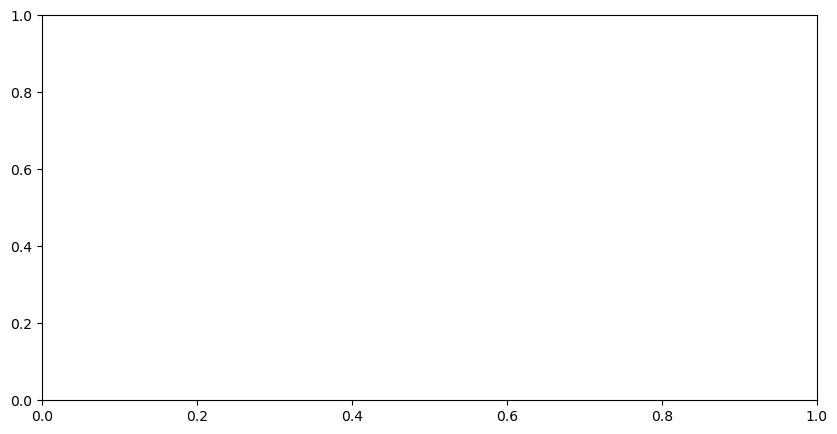

In [33]:
fig, ax = plt.subplots(figsize = (10, 5))
# ax.scatter(range(len(axis_trans)), axis_trans)
ax.scatter(axis_trans, np.zeros(axis_trans_df.shape), marker='o', edgecolors='black', s=200, c = sensory_pcoords[:, 5] )
ax.set_xlabel('Value')
ax.yaxis.set_visible(False)
ax.set_title('One-Dimensional Data Visualization on a Single Axis')


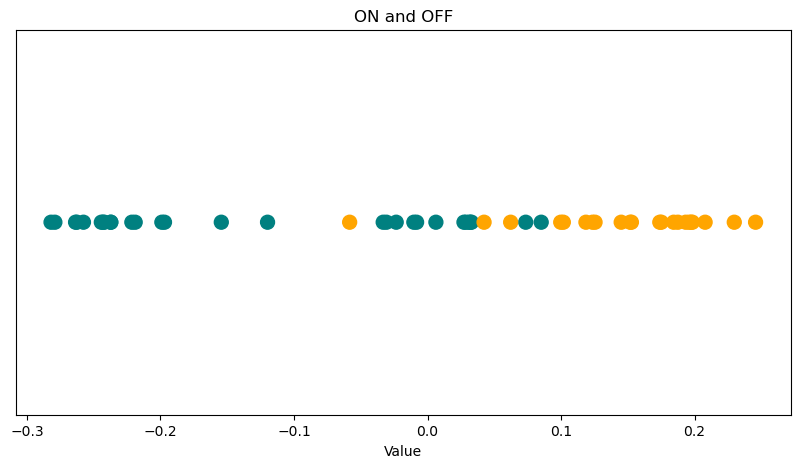

In [32]:
axis_trans_df.columns = ['Value', 'Category']

# Create a color map manually
color_map = {
    'ON': 'teal',  # Color for 'ON'
    'OFF': 'orange'  # Color for 'OFF'
}

# Map labels to colors using the color map
label_colors = axis_trans_df['Category'].map(color_map)

# Create scatter plot with specified figure size
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(axis_trans_df['Value'], [0] * len(axis_trans_df), c=label_colors, s=100)
ax.set_xlabel('Value')
ax.yaxis.set_visible(False)

ax.set_title('ON and OFF')

plt.show()

In [37]:
ON = axis_trans_df[axis_trans_df['Category'] == 'ON']['Value']
OFF = axis_trans_df[axis_trans_df['Category'] == 'OFF']['Value']

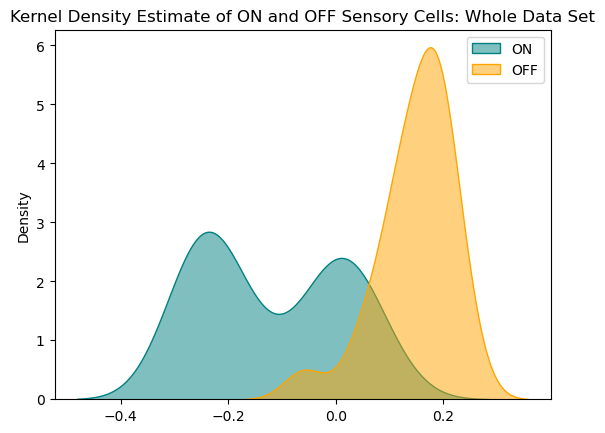

In [38]:
# Plotting KDE for each category
sns.kdeplot(ON, color='teal', fill=True, alpha=0.5, label='ON')
sns.kdeplot(OFF, color='orange', fill=True, alpha=0.5, label='OFF')

# Adding labels and title
plt.xlabel('')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of ON and OFF Sensory Cells: Whole Data Set')
plt.legend()

# Show the plot
plt.show()